# Homework 8 - Renormalization Group #

# Consegna #

Consider the quantum Ising Hamiltonian in transverse field on a one-dimensional lattice with the nearest neighbour interaction:
$$
\hat{H} = \lambda {\sum_i}^N {\sigma_i}^z + {\sum_i}^{N-1} {\sigma_i}^x {\sigma_{i+1}}^x 
$$

where $\sigma^x$ and $\sigma^z$ and $\lambda$ is the transverse field. 

(a) Compute the ground state energy as a function of the transverse field 𝜆 by means of the real-space
RG algorithm.

(b) $\textit{Optional}$: Compute the ground state energy as a function of 𝜆 by means of the INFINITE DMRG
algorithm. Compare the results between them and with the mean field solution.


**Teoria a pag. pdf 49 del libro di Montangero**

Real-space renormalization group method is an approximation method based on a very powerful physical intuition: the hypothesis that the ground state of a system is composed of low-energy states of the system’s (non-interacting) bipartitions. Based on this assumption, it is indeed possible to introduce an algorithm that allows describing the ground state properties of many-body quantum systems with large sizes $( N )$, up to the thermodynamical limit corresponding to the fixed point of the renormalization flow.

The algorithm proceeds as follows:

1. **Initialize**:  
   Consider a system composed of $( N )$ sites that can be studied in an exact numerical way. Build the Hamiltonian $( H_N : \mathbb{C}^{dN} \to \mathbb{C}^{dN} )$.

2. **Diagonalize the Hamiltonian**:  
   Diagonalize $( H_N )$, finding its eigenvalues and eigenvectors:
   $$
   H_N = \sum_{i=1}^{d^N} E_i \lvert E_i \rangle \langle E_i \rvert,
   $$
   where the eigenvalues $( E_i )$ are in increasing order.  
   Consider the projector onto the lowest $( m )$ eigenstates:
   $$
   P = \sum_{i=1}^m \lvert E_i \rangle \langle E_i \rvert,
   $$
   which projects the Hilbert space onto the subspace spanned by the first $( m )$ low-energy eigenstates.  
   Compute the projected Hamiltonian:
   $$
   \tilde{H}_N = P^\dagger H_N P,
   $$
   as well as any other needed operator representation in the projected space:
   $$
   \tilde{O} = P^\dagger O P.
   $$

3. **Construct the larger system Hamiltonian**:  
   Construct the Hamiltonian of a system of size $( 2N )$ using the projected Hamiltonian $( \tilde{H}_N )$ for each bipartition and the interaction among them:
   $$
   H_{2N} = \tilde{H}_N \otimes 1 + 1 \otimes \tilde{H}_N + \tilde{H}_{\text{int}}.
   $$
   The interaction Hamiltonian can be obtained as:
   $$
   \tilde{H}_{\text{int}} = \tilde{A}_N \otimes \tilde{B}_N,
   $$
   where $( \tilde{A} )$ ($( \tilde{B} )$) are the projected operators acting on each system bipartition:
   $$
   \tilde{A} = P^\dagger A P, \quad \tilde{B} = P^\dagger B P.
   $$

4. **Repeat until convergence**:  
   Repeat steps 2–3 until the desired system size is reached or convergence to the renormalization group fixed point is achieved.  
   At each step of the algorithm, the dimension of the described system is doubled ($( N \to 2N )$) while the dimension of the Hamiltonian representation is kept constant at $( m )$.



**metti a posto le formule in latex**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aux
import ising as ig
import scipy.sparse as sp
import density_matrix_functions as dm

In [7]:
def proj(ham, m):
    _, eigenvectors = sp.linalg.eigsh(ham, k= m, which='SA')     # they're alrady sorted in ascending order
    proj = sp.csr_matrix(eigenvectors)
    return proj

def initialize_part(N):
    
    sigma_x, _, _ = aux.pauli_matrices()
    
    A_0 = sp.kron(sp.identity(2**(N-1),format='csr'),sigma_x)
    B_0 = sp.kron(sigma_x,sp.identity(2**(N-1),format='csr'))
    return A_0, B_0

def ham_2N(ham,A,B):
    left = sp.kron(ham,sp.identity(ham.shape[0],format='csr'))
    right = sp.kron(sp.identity(ham.shape[0],format='csr'),ham)
    AB = sp.kron(A,B)
    ham2N = left + right + AB
    if ham2N.shape != (int(2**(2*np.log2(ham.shape[0]))),int(2**(2*np.log2(ham.shape[1])))):
        aux.checkpoint(True,verb=3,
                       msg='Shapes of new Hamiltonian should be = 2*(shape of the original Hamiltonian).Instead got', var=ham2N.shape)
    return ham2N

def update_op(N, ham2N, A, B, m):
    P = proj(ham2N,m)
    P_dag = P.conj().T
    ham_new = P_dag @ ham2N @ P
    A_new = P_dag @ sp.kron(sp.identity(2**N,format='csr'),A) @ P
    B_new = P_dag @ sp.kron(B,sp.identity(2**N,format='csr')) @ P
    return ham_new, A_new, B_new

def energy_conv(N, ham, ham_new, m, tau, verb: int=1):
    N_new = 2 * N
    print('Ham:', ham.shape)
    eigvals, _ = sp.linalg.eigsh(ham, m, which='SA')
    eigvals_new, _ = sp.linalg.eigsh(ham_new, m, which='SA')
    E = eigvals[0]
    E_new = eigvals_new[0]
    condition = np.abs(E_new/N_new - E/N) < tau
    if verb == 1:
        if condition:
            print('Convergence reached!')
    if verb == 2:
        if condition:
            print('Convergence reached!')
        return condition, E_new/N_new, E/N
    if verb > 2:
        if condition:
            print('Convergence reached!')
            print(f'Energy density at previous step: {E/N}')
            print(f'Energy density at current step: {E_new/N_new}')
        else: 
            print(f'Energy density at previous step: {E/N}')
            print(f'Energy density at current step: {E_new/N_new}')
        return condition, E_new/N_new, E/N
    

def real_space_rg(N, m, tau, lam: float=1.0, max_iterations: int =100):
    
    prev_energy_density = np.inf
    ham = ig.sparse_ising(N,lam)
    A, B = initialize_part(N)
    curr_N = N
    
    # Initialize a list for the energies
    energy_densities = np.zeros(max_iterations)
    deltas = np.zeros(max_iterations)

    for it in range(1,max_iterations):
        curr_N *= 2
        if it % 10 == 0:
            print(f"Starting iteration {it} ...")
        
        # Compute the new Hamiltonian
        ham2N = ham_2N(ham, A, B)
        
        # Compute the new energy 
        E_curr, _ = sp.linalg.eigsh(ham2N, k=m,which='SA')
        curr_energy_density = E_curr[0]/curr_N
        delta = np.abs(curr_energy_density - prev_energy_density)
        
        # Append the energy to the energy list
        energy_densities[it] = curr_energy_density
        deltas[it] = delta
        
        if delta < tau:
            print(f'Convergence reached at N = {curr_N} with precision delta {delta} after {it} iterations.')
            return energy_densities, deltas, it, curr_N
        
        prev_energy_density = curr_energy_density 
            
        # update
        ham, A, B = update_op(N, ham2N,A,B,m)
    
    print('Maximum iterations reached!')
    return energy_densities, deltas, it, curr_N
        


Starting iteration 10 ...
Convergence reached at N = 16384 with precision delta 9.992007221626409e-15 after 13 iterations.


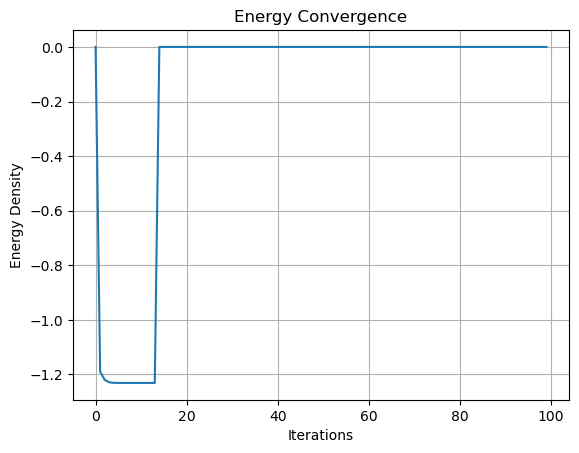

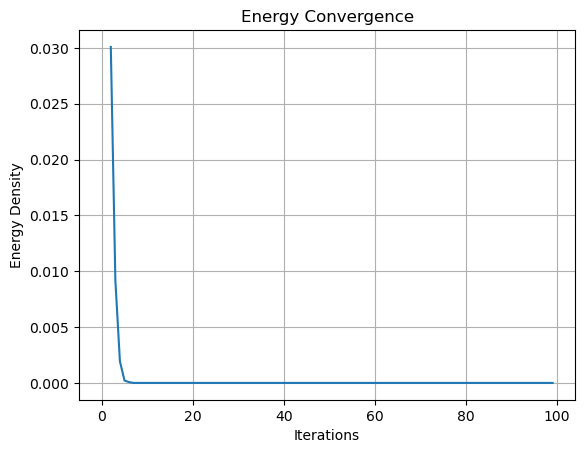

In [4]:
# for the Hamiltonian I use the code already developed for the previous assignment

N = 2
lam = 1
m = 2**N
tau = 1e-14
max_iter = 100

energy_densities, deltas, it, _ = real_space_rg(N=N, m=m, tau=tau,lam=lam, max_iterations=max_iter)

plt.plot(np.arange(100), energy_densities)
plt.xlabel('Iterations')
plt.ylabel('Energy Density')
plt.title('Energy Convergence')
plt.grid()
plt.show()

plt.plot(np.arange(100), deltas)
plt.xlabel('Iterations')
plt.ylabel('Energy Density')
plt.title('Energy Convergence')
plt.grid()
plt.show()



########## Computing for N = 2 ############
Starting iteration 10 ...
Starting iteration 20 ...
Starting iteration 30 ...
Starting iteration 40 ...
Convergence reached at N = 562949953421312 with precision delta 6.217248937900877e-15 after 48 iterations.
Starting iteration 10 ...
Starting iteration 20 ...
Starting iteration 30 ...
Convergence reached at N = 8589934592 with precision delta 7.771561172376096e-15 after 32 iterations.
Starting iteration 10 ...
Starting iteration 20 ...
Starting iteration 30 ...
Starting iteration 40 ...
Starting iteration 50 ...
Convergence reached at N = 2251799813685248 with precision delta 6.217248937900877e-15 after 50 iterations.
Starting iteration 10 ...
Convergence reached at N = 16384 with precision delta 2.220446049250313e-16 after 13 iterations.
Starting iteration 10 ...
Convergence reached at N = 16384 with precision delta 2.220446049250313e-15 after 13 iterations.
Starting iteration 10 ...
Convergence reached at N = 16384 with precision delta 1

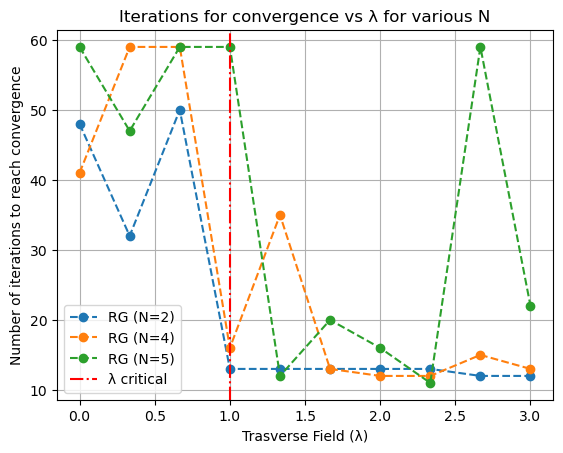

In [8]:
tau = 1e-14
max_iter = 60

N_vals = [2,4,5]
l_vals = np.linspace(0,3,10)
n_iter = np.zeros((len(N_vals),l_vals.shape[0]))
final_dims = np.zeros((len(N_vals),l_vals.shape[0]))
energies =  np.zeros((len(N_vals),l_vals.shape[0], max_iter))
deltas_tot =  np.zeros((len(N_vals),l_vals.shape[0],max_iter))
for i,N in enumerate(N_vals):
    print(f'########## Computing for N = {N} ############')
    for j,lam in enumerate(l_vals):
        
        energy_densities, deltas, it, final_dim = real_space_rg(N=N, m=2**N, tau=tau,lam=lam, max_iterations=max_iter)
        
        energies[i,j,:] = energy_densities
        deltas_tot[i,j,:] = deltas
        n_iter[i,j] = it
        final_dims[i,j] = final_dim
    
    plt.plot(l_vals, n_iter[i,:], label=f'RG (N={N})', marker='o', linestyle='--')

plt.axvline(x=1.0, c='r', label='λ critical', linestyle='-.')
plt.grid()
plt.legend()
plt.title('Iterations for convergence vs λ for various N')
plt.xlabel('Trasverse Field (λ)')
plt.ylabel('Number of iterations to reach convergence')
plt.savefig('Figures/lam_it.png')
plt.show()
    

## Infinite Density Matrix RG ##

In [ ]:


def initialize_operators(m, l):

  s_x, _, s_z = aux.pauli_matrices()
  
  A_L_0 = A_R_0 = sp.identity(2**m, format='csr')
  B_L_0 = sp.kron(sp.identity(2**(m - 1), format='csr'), s_x)
  B_R_0 = sp.kron(s_x, sp.identity(2**(m - 1), format='csr'))
  
  H_L_0 = H_R_0 = ig.sparse_ising(m, l)
  
  return A_L_0, B_L_0, A_R_0, B_R_0, H_L_0, H_R_0


def compute_H_LR(H_L, H_R, A_L, B_L, A_R, B_R, l):
  s_x, _, s_z = aux.pauli_matrices()
  H_L1 = sp.kron(H_L, sp.identity(2, format='csr')) + sp.kron(A_L, l * s_z) + sp.kron(B_L, s_x)
  H_R1 = sp.kron(sp.identity(2, format='csr'), H_R) + sp.kron(l * s_z, A_R) + sp.kron(s_x, B_R)
  return H_L1, H_R1


def update_operators(A_L, A_R):
  s_x, _, _ = aux.pauli_matrices()
  
  A_L_new = sp.kron(A_L, sp.identity(2, format='csr'))
  B_L_new = sp.kron(sp.identity(2, format='csr'), s_x)
  
  A_R_new = sp.kron(sp.identity(2, format='csr'), A_R)
  B_R_new = sp.kron(s_x, sp.identity(2, format='csr'))
  
  return A_L_new, B_L_new, A_R_new, B_R_new


def compute_H_2m(H_L1, H_R1, m):
  s_x, _, _ = aux.pauli_matrices()
  I_m = sp.identity(2**(m), format='csr')
  I_m1 = sp.identity(H_R1.shape[1], format='csr')
  
  H_int = sp.kron(s_x, s_x)
  H_LR = sp.kron(I_m, sp.kron(H_int, I_m))
  
  H_2m = (sp.kron(H_L1, I_m1) + sp.kron(I_m1, H_R1) + H_LR)
  
  return H_2m


def projector(rho_L, k):
  
  if k > rho_L.shape[0]:
    raise ValueError(f"'k' must be <= the dimension of rho_L, got k={k} and dim={rho_L.shape[0]}")

  _, eigvecs = sp.linalg.eigsh(rho_L, k=k, which='LA')  # Compute the largest `k` eigenvalues
  proj = sp.csr_matrix(eigvecs)
  return proj


def truncate_operators(P_L, P_R, A_L, B_L, A_R, B_R, H_L, H_R):
  P_L_dagger = P_L.conj().T
  P_R_dagger = P_R.conj().T
  
  A_L_trunc = P_L_dagger @ A_L @ P_L
  B_L_trunc = P_L_dagger @ B_L @ P_L
  H_L_trunc = P_L_dagger @ H_L @ P_L
  
  A_R_trunc = P_R_dagger @ A_R @ P_R
  B_R_trunc = P_R_dagger @ B_R @ P_R
  H_R_trunc = P_R_dagger @ H_R @ P_R

  return A_L_trunc, B_L_trunc, A_R_trunc, B_R_trunc, H_L_trunc, H_R_trunc


def infinite_dmrg(l, m_max, threshold=1e-6, max_iter=100):

  # Initialize operators and Hamiltonians
  m = 1  # Initial single-site system
  A_L, B_L, A_R, B_R, H_L, H_R = initialize_operators(m, l)

  curr_dim = 2 * m
  prev_energy_density = np.inf
  
  for iteration in range(max_iter):
    # Step 1: Enlarge Hamiltonians
    H_L1, H_R1 = compute_H_LR(H_L, H_R, A_L, B_L, A_R, B_R, l)
    
    # Step 2: Combine into full system Hamiltonian
    H_2m = compute_H_2m(H_L1, H_R1, m)
    
    # Step 3: Compute the ground state and wavefunction
    E, psi = sp.linalg.eigsh(H_2m, k=1, which='SA')
    E_ground = E[0]
    psi_ground = psi[:, 0]
    
    # Step 4: Compute reduced density matrix
    N = int(np.log2(H_2m.shape[0]))
    D = 2  # Local Hilbert space dimension
    left_indices = list(range(0, N // 2))  # Keep left block sites
    rho_L = rdm(psi_ground, N, D, left_indices)
    
    right_indices = list(range(N // 2, N))  # Keep left block sites
    rho_R = rdm(psi_ground, N, D, right_indices)
    

    # Step 5: Construct the projector
    k = min(2 ** m_max, rho_L.shape[0] - 1)  # Ensure k does not exceed the dimension
    P_L = projector(rho_L, k)
    P_R = projector(rho_R, k)
    
    # Step 6: Truncate operators and Hamiltonians
    A_L, B_L, A_R, B_R = update_operators(A_L, B_L, A_R, B_R)
    A_L, B_L, A_R, B_R, H_L, H_R = truncate_operators(P_L, P_R, A_L, B_L, A_R, B_R, H_L1, H_R1)
        
    # Step 7: Check convergence
    curr_dim += 2
    current_energy_density = E_ground / curr_dim
    delta = abs(current_energy_density - prev_energy_density)

    if delta < threshold:
      print(f"Converged after {iteration + 1} iterations.")
      break

    # Update for the next iteration
    prev_energy_density = current_energy_density
      
    if iteration % 10 == 0:
      print(f"Starting iteration {iteration} ...")
    
  print(f"Reached N = {curr_dim} with precision: delta = {delta}")
  return current_energy_density, E_ground, psi_ground
  

def update_hamiltonian(l_values, m_max, threshold, max_iter=100):
  # Initialize dictionaries to store eigenvalues and eigenvectors
  gs_density_dict = {}
  gs_energy_dict = {}
  gs_dict = {}
  
  print(f"Analysis with N={2*(max_iter+1)}...")

  for l in l_values:      
    energy_density_ground, E_ground, psi_ground = infinite_dmrg(l, m_max, threshold, max_iter)  
    
    gs_density_dict[(2*(max_iter+1), l)] = energy_density_ground
    gs_energy_dict[(2*(max_iter+1), l)] = E_ground
    gs_dict[(2*(max_iter+1), l)] = psi_ground
    
  print("-----------------------------------------")
    
  return gs_density_dict, gs_energy_dict, gs_dict